<H1>Zen of Python: “practicality beats purity”

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
import lifetime_value as ltv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import tqdm
from typing import Sequence
from numpy import inf
import pandas as pd

In [2]:
from scipy import stats

In [3]:
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param { isTemplate: true, type: 'integer'}

In [4]:
#levanto la info
customer_level_data = spark.sql("""
SELECT * FROM tmp.base_ltv_dec2018_c
""")

In [5]:
#Paso a pandas
df = customer_level_data.toPandas()

In [6]:
#reviso lo levantado
df.head(20)

,orden,user_id,transaction_id,fecha_1er_compra,pais,plataforma,producto,viaje,items,income,income_post_compra,gb,paxs,duracion,anticipacion,gb_anual
0,1,5d04d3fc-754b-4624-b691-94c3a3d6baf3,731106075700,2018-12-19,MX,Site-Desktop,Vuelos,Nac,1,LOW,LOW,90.088203,2,0,40.0,NaN
1,1,34c9fe0c-7302-48b7-843f-c6e001c8e690,749178075400,2018-12-16,CL,Site-Mobile,Vuelos,Nac,1,LOW,LOW,58.447838,1,5,23.0,NaN
2,1,1a6e0b00-1acd-42a2-853c-0788be31d833,23111532601,2018-12-17,BR,App,Vuelos,Nac,1,HIGH,HIGH,47.025703,1,0,7.0,NaN
3,1,ee8669a8-f354-4542-98f8-89181351163a,23278279101,2018-12-25,MX,Site-Mobile,Vuelos,Nac,1,LOW,LOW,196.398956,2,0,1.0,240.379105
4,1,5919e470e4b0b05c0f7e0992,22909174101,2018-12-09,BR,App,Vuelos,Nac,1,MEDIUM,MEDIUM,93.969040,1,1,188.0,8.309073
5,1,c598b3ca-971d-4ce0-a9af-0176487f4c5c,22743500101,2018-12-03,CO,App,Vuelos,Int,1,MEDIUM,HIGH,804.181763,1,63,73.0,1315.287354
6,1,736ca634-c4d2-47f3-a74a-04b5b2512b78,304121076700,2018-12-29,AR,Site-Desktop,Vuelos,Int,1,MEDIUM,HIGH,528.012512,1,10,7.0,203.652496
7,1,68f799cb-2d5b-4b64-963f-588469d2f7b7,116327074900,2018-12-11,AR,Site-Desktop,Vuelos,Nac,1,HIGH,HIGH,138.479599,1,0,25.0,NaN
8,1,7a0e2d89-6c5e-4c28-b838-881ed0971316,437445075600,2018-12-18,CO,Site-Desktop,Vuelos,Nac,1,LOW,LOW,132.386337,1,4,2.0,NaN
9,1,57c4f6dfe4b031115fdaae45,516721075100,2018-12-13,BR,App,Actividades,Int,1,LOW,LOW,1453.387085,4,0,9.0,11403.881607


In [7]:
#Defino las features
CATEGORICAL_FEATURES = ['pais', 'plataforma', 'producto', 'income_post_compra', 'viaje']
NUMERIC_FEATURES = ['items', 'gb', 'paxs', 'duracion', 'anticipacion', 'gb_anual']

In [8]:
#me quedo con las que me interesan
df = df[CATEGORICAL_FEATURES + NUMERIC_FEATURES]

In [9]:
#completo los campos vacíos
df['gb_anual'] = df['gb_anual'].fillna(0.)
df['income_post_compra'] = df['income_post_compra'].fillna('UNKNOWN')
df['duracion']  = df['duracion'].fillna(0.)

In [10]:
compradores = df[df['gb_anual'] > 0]
compradores.describe()

,items,gb,anticipacion,gb_anual
count,62748.000000,62748.000000,62748.000000,62748.000000
mean,1.153471,471.647422,35.397144,710.753052
std,0.548042,671.363752,47.244316,1272.329725
min,1.000000,2.362210,-1.000000,1.348252
25%,1.000000,101.988901,5.000000,128.700121
50%,1.000000,234.560417,19.000000,317.693390
75%,1.000000,576.106781,45.000000,789.979062
max,11.000000,17649.812500,386.000000,56908.841175


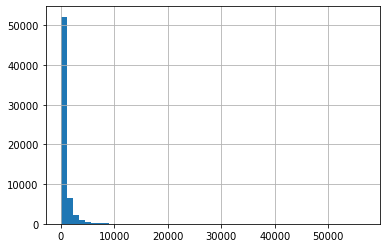

In [11]:
plot_ = compradores['gb_anual'].hist(bins=50)
plot_

In [12]:
df = df[df['gb_anual']+df['gb'] < 10000].reset_index(drop=True)

In [13]:
len(df)

203427

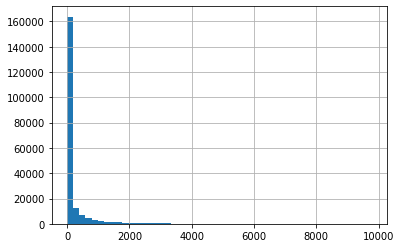

In [14]:
plot = df['gb_anual'].hist(bins=50)
plot

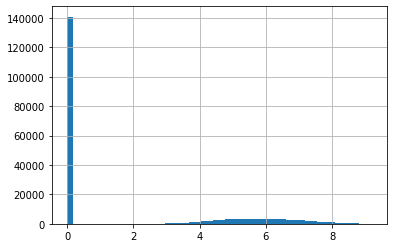

In [15]:
plot2 = df['gb_anual'].apply(np.log1p).hist(bins=50)
plot2

In [16]:
df['gb_anual'].nlargest(3)

73847     9775.774780
187810    9717.566991
170766    9422.317993
Name: gb_anual, dtype: float64

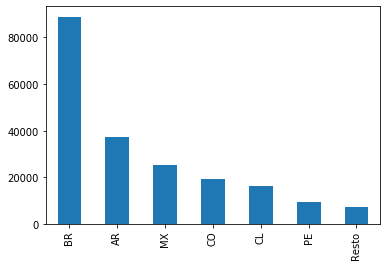

In [17]:
df['pais'].value_counts().plot(kind='bar')

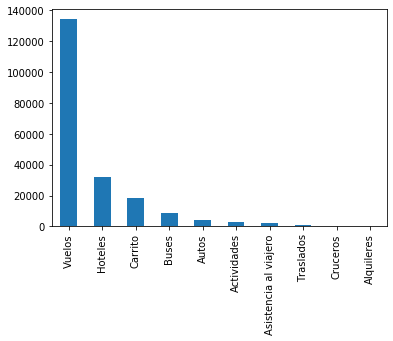

In [18]:
df['producto'].value_counts().plot(kind='bar')

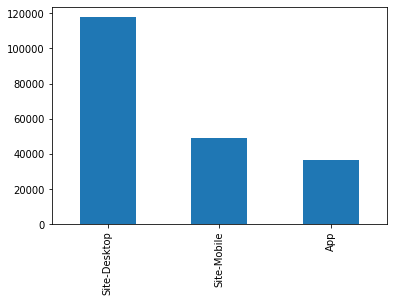

In [19]:
df['plataforma'].value_counts().plot(kind='bar')

In [21]:
df.head()

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual
0,MX,Site-Desktop,Vuelos,LOW,Nac,1,90.088203,2,0,40.0,0.000000
1,CL,Site-Mobile,Vuelos,LOW,Nac,1,58.447838,1,5,23.0,0.000000
2,BR,App,Vuelos,HIGH,Nac,1,47.025703,1,0,7.0,0.000000
3,MX,Site-Mobile,Vuelos,LOW,Nac,1,196.398956,2,0,1.0,240.379105
4,BR,App,Vuelos,MEDIUM,Nac,1,93.969040,1,1,188.0,8.309073


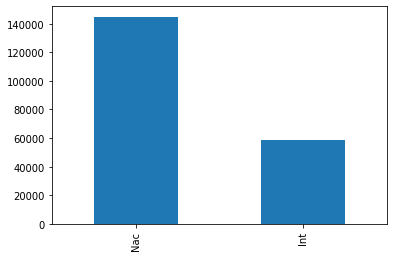

In [22]:
df['viaje'].value_counts().plot(kind='bar')

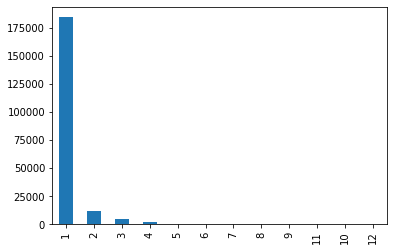

In [23]:
df['items'].value_counts().plot(kind='bar')

In [24]:
df.iloc[df['items'].nlargest(1).index]

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual
16585,BR,Site-Desktop,Carrito,LOW,Nac,12,1889.374936,2,8,11.0,0.0


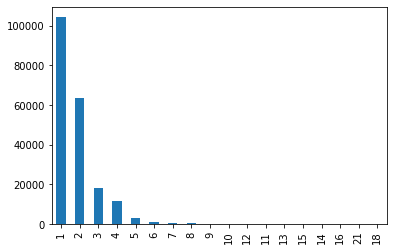

In [25]:
df['paxs'].value_counts().plot(kind='bar')

In [26]:
df[df['paxs'] == '18']

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual
118262,MX,App,Hoteles,UNKNOWN,Nac,1,1113.611572,18,4,23.0,0.0


In [27]:
df['log_gb'] = (
      np.log(df['gb']).astype('float32'))

In [28]:
for cat_col in CATEGORICAL_FEATURES:
    df[cat_col] = df[cat_col].astype('category')

for num_col in NUMERIC_FEATURES:
    df[num_col] = df[num_col].astype('float32')

    

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203427 entries, 0 to 203426
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   pais                203427 non-null  category
 1   plataforma          203427 non-null  category
 2   producto            203427 non-null  category
 3   income_post_compra  203427 non-null  category
 4   viaje               203427 non-null  category
 5   items               203427 non-null  float32 
 6   gb                  203427 non-null  float32 
 7   paxs                203427 non-null  float32 
 8   duracion            203427 non-null  float32 
 9   anticipacion        203427 non-null  float32 
 10  gb_anual            203427 non-null  float32 
 11  log_gb              203427 non-null  float32 
dtypes: category(5), float32(7)
memory usage: 6.4 MB


In [30]:
df.head()

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual,log_gb
0,MX,Site-Desktop,Vuelos,LOW,Nac,1.0,90.088203,2.0,0.0,40.0,0.000000,4.500789
1,CL,Site-Mobile,Vuelos,LOW,Nac,1.0,58.447838,1.0,5.0,23.0,0.000000,4.068135
2,BR,App,Vuelos,HIGH,Nac,1.0,47.025703,1.0,0.0,7.0,0.000000,3.850694
3,MX,Site-Mobile,Vuelos,LOW,Nac,1.0,196.398956,2.0,0.0,1.0,240.379105,5.280148
4,BR,App,Vuelos,MEDIUM,Nac,1.0,93.969040,1.0,1.0,188.0,8.309073,4.542965


In [31]:
#Miro los que más gb_anual tienen
df.iloc[df['gb_anual'].nlargest(30).index]

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual,log_gb
73847,MX,Site-Mobile,Vuelos,LOW,Nac,1.0,89.653778,1.0,0.0,1.0,9775.774414,4.495955
187810,MX,App,Vuelos,MEDIUM,Nac,1.0,106.997383,1.0,0.0,1.0,9717.567383,4.672804
170766,BR,Site-Desktop,Vuelos,HIGH,Nac,1.0,135.212799,1.0,2.0,57.0,9422.318359,4.906850
158828,AR,Site-Desktop,Vuelos,HIGH,Nac,1.0,459.244995,1.0,3.0,0.0,9293.845703,6.129584
40916,MX,Site-Mobile,Vuelos,LOW,Nac,1.0,272.893555,1.0,2.0,5.0,9286.003906,5.609082
110234,MX,App,Vuelos,HIGH,Nac,1.0,120.809921,1.0,4.0,1.0,9237.379883,4.794219
77752,BR,Site-Desktop,Vuelos,MEDIUM,Nac,1.0,272.700409,1.0,1.0,33.0,9202.465820,5.608374
42869,CL,Site-Desktop,Vuelos,HIGH,Nac,1.0,174.277145,1.0,4.0,19.0,9166.659180,5.160647
138124,MX,Site-Desktop,Hoteles,HIGH,Nac,1.0,373.304077,2.0,4.0,43.0,9141.104492,5.922393
114348,CL,Site-Desktop,Asistencia al viajero,LOW,Int,1.0,156.400848,2.0,16.0,135.0,9095.753906,5.052422


In [32]:
df.head(20)

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual,log_gb
0,MX,Site-Desktop,Vuelos,LOW,Nac,1.0,90.088203,2.0,0.0,40.0,0.000000,4.500789
1,CL,Site-Mobile,Vuelos,LOW,Nac,1.0,58.447838,1.0,5.0,23.0,0.000000,4.068135
2,BR,App,Vuelos,HIGH,Nac,1.0,47.025703,1.0,0.0,7.0,0.000000,3.850694
3,MX,Site-Mobile,Vuelos,LOW,Nac,1.0,196.398956,2.0,0.0,1.0,240.379105,5.280148
4,BR,App,Vuelos,MEDIUM,Nac,1.0,93.969040,1.0,1.0,188.0,8.309073,4.542965
5,CO,App,Vuelos,HIGH,Int,1.0,804.181763,1.0,63.0,73.0,1315.287354,6.689826
6,AR,Site-Desktop,Vuelos,HIGH,Int,1.0,528.012512,1.0,10.0,7.0,203.652496,6.269120
7,AR,Site-Desktop,Vuelos,HIGH,Nac,1.0,138.479599,1.0,0.0,25.0,0.000000,4.930723
8,CO,Site-Desktop,Vuelos,LOW,Nac,1.0,132.386337,1.0,4.0,2.0,0.000000,4.885725
9,BR,App,Vuelos,UNKNOWN,Nac,1.0,390.267792,1.0,20.0,12.0,0.000000,5.966833


In [33]:
def dnn_split(df):
    for key in CATEGORICAL_FEATURES:
        encoder = preprocessing.LabelEncoder()
        df[key] = encoder.fit_transform(df[key])
    
    y0 = df['gb'].values #calibration_value
    df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(df, y0, test_size=0.2, random_state=123)
    
    def feature_dict(df):
        features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
        features['numeric'] = df['log_gb'].values
        return features
    
    x_train, y_train = feature_dict(df_train), df_train['gb_anual'].values #label
    x_eval, y_eval = feature_dict(df_eval), df_eval['gb_anual'].values #label
    
    return x_train, x_eval, y_train, y_eval, y0_eval

In [34]:
X_train, X_eval, y_train, y_eval, y0_eval = dnn_split(df)

In [35]:
X_train

{'pais': array([1, 1, 2, ..., 4, 5, 0]),
 'plataforma': array([1, 1, 2, ..., 2, 1, 2]),
 'producto': array([9, 9, 9, ..., 7, 9, 8]),
 'income_post_compra': array([1, 2, 2, ..., 2, 1, 0]),
 'viaje': array([1, 1, 0, ..., 1, 1, 0]),
 'numeric': array([5.463899 , 5.02171  , 6.582321 , ..., 6.3547854, 4.4426513,
        2.3025892], dtype=float32)}

In [36]:
y_train

array([   0.     ,    0.     ,  387.30902, ..., 2063.279  ,    0.     ,
          0.     ], dtype=float32)

In [37]:
def embedding_dim(x):
    return int(x**.25) + 1


def embedding_layer(vocab_size):
    return tf.keras.Sequential([tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim(vocab_size),
        input_length=1),
        tf.keras.layers.Flatten(),
        ])


def dnn_model(output_units, df):
    numeric_input = tf.keras.layers.Input(shape=(len(['log_gb']),), name='numeric')
    
    embedding_inputs = [
        tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64) 
        for key in CATEGORICAL_FEATURES
    ]
    
    embedding_outputs = [
      embedding_layer(vocab_size=df[key].nunique())(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
    ]
    
    deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
    deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
    
    return tf.keras.Model(inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

In [38]:
loss = ltv.zero_inflated_lognormal_loss
output_units = 3

model = dnn_model(output_units, df)

In [39]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [40]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.TerminateOnNaN(), 
]

In [41]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_eval, y_eval)).history

Train on 162741 samples, validate on 40686 samples
Epoch 1/400
162741/162741 - 6s - loss: 7.0926 - val_loss: 4.8384
Epoch 2/400
162741/162741 - 2s - loss: 4.2541 - val_loss: 3.8736
Epoch 3/400
162741/162741 - 2s - loss: 3.6468 - val_loss: 3.4932
Epoch 4/400
162741/162741 - 2s - loss: 3.3640 - val_loss: 3.2468
Epoch 5/400
162741/162741 - 3s - loss: 3.1401 - val_loss: 3.0869
Epoch 6/400
162741/162741 - 3s - loss: 3.0279 - val_loss: 2.9953
Epoch 7/400
162741/162741 - 2s - loss: 2.9491 - val_loss: 2.9364
Epoch 8/400
162741/162741 - 2s - loss: 2.9117 - val_loss: 2.9174
Epoch 9/400
162741/162741 - 2s - loss: 2.9004 - val_loss: 2.9104
Epoch 10/400
162741/162741 - 2s - loss: 2.8939 - val_loss: 2.9043
Epoch 11/400
162741/162741 - 2s - loss: 2.8878 - val_loss: 2.8987
Epoch 12/400
162741/162741 - 2s - loss: 2.8824 - val_loss: 2.8938
Epoch 13/400
162741/162741 - 3s - loss: 2.8777 - val_loss: 2.8889
Epoch 14/400
162741/162741 - 3s - loss: 2.8726 - val_loss: 2.8846
Epoch 15/400
162741/162741 - 3s - 

162741/162741 - 3s - loss: 2.8461 - val_loss: 2.8617
Epoch 125/400
162741/162741 - 2s - loss: 2.8461 - val_loss: 2.8619
Epoch 126/400
162741/162741 - 2s - loss: 2.8460 - val_loss: 2.8621
Epoch 127/400
162741/162741 - 2s - loss: 2.8460 - val_loss: 2.8618
Epoch 128/400
162741/162741 - 2s - loss: 2.8460 - val_loss: 2.8615
Epoch 129/400
162741/162741 - 3s - loss: 2.8459 - val_loss: 2.8618
Epoch 130/400
162741/162741 - 2s - loss: 2.8459 - val_loss: 2.8620
Epoch 131/400
162741/162741 - 3s - loss: 2.8459 - val_loss: 2.8616
Epoch 132/400
162741/162741 - 2s - loss: 2.8458 - val_loss: 2.8616
Epoch 133/400
162741/162741 - 2s - loss: 2.8458 - val_loss: 2.8616
Epoch 134/400
162741/162741 - 2s - loss: 2.8458 - val_loss: 2.8617
Epoch 135/400
162741/162741 - 2s - loss: 2.8457 - val_loss: 2.8615
Epoch 136/400
162741/162741 - 3s - loss: 2.8458 - val_loss: 2.8616
Epoch 137/400
162741/162741 - 3s - loss: 2.8457 - val_loss: 2.8619
Epoch 138/400
162741/162741 - 3s - loss: 2.8457 - val_loss: 2.8614
Epoch 139

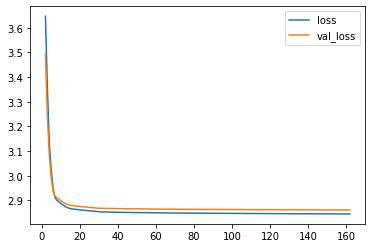

In [42]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

In [43]:
logits = model.predict(x=X_eval, batch_size=1024)
y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

In [44]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(20)

,y_true,y_pred
0,0.000000,82.130516
1,0.000000,104.269279
2,0.000000,311.356232
3,0.000000,155.805695
4,0.000000,82.721741
5,0.000000,106.808411
6,0.000000,152.623398
7,978.176941,282.970764
8,223.889099,165.343628
9,0.000000,80.750946


In [45]:
df_pred.tail(50)

,y_true,y_pred
40636,0.000000,109.621025
40637,768.676270,579.061462
40638,0.000000,429.884369
40639,473.836792,552.869202
40640,558.166626,272.109894
40641,0.000000,102.056717
40642,0.000000,104.953049
40643,0.000000,139.763062
40644,0.000000,262.526062
40645,0.000000,86.873856


In [46]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [47]:
df_pred = df_pred.sort_values(by='y_pred').reset_index(drop=True)
df_pred.head(20)

,y_true,y_pred
0,0.000000,7.699533
1,0.000000,9.354201
2,0.000000,16.596901
3,303.943115,16.874914
4,4.675252,16.920269
5,0.000000,17.604748
6,5.170352,18.194733
7,0.000000,18.276363
8,0.000000,18.598717
9,4.808684,18.726511


In [48]:
df_pred['decile'] = pd.qcut(df_pred['y_pred'].rank(method='first'), 10, labels=[i for i in range(10)])

In [49]:
df_pred['buyer'] = df_pred['y_true'].apply(lambda x: 1 if x > 0 else 0)

In [50]:
df_pred.tail(30)

,y_true,y_pred,decile,buyer
40656,0.000000,1244.577026,9,0
40657,0.000000,1247.287231,9,0
40658,2045.630859,1252.143433,9,1
40659,110.252518,1260.722900,9,1
40660,0.000000,1271.535034,9,0
40661,455.939453,1280.419922,9,1
40662,3377.792725,1283.519775,9,1
40663,0.000000,1283.846924,9,0
40664,0.000000,1288.104248,9,0
40665,0.000000,1291.300537,9,0


In [51]:
pivot = pd.pivot_table(df_pred, values=['y_true', 'y_pred', 'buyer'], index='decile',
                    aggfunc={'y_true': [min, max,len, np.mean, sum],
                             'y_pred': [min, max,len, np.mean, sum],
                             'buyer': sum
                             })

pivot

buyer  y_pred                                                     \
         sum     len          max        mean         min           sum   
decile                                                                    
0       1103  4069.0    78.375664   61.249241    7.699533  2.492232e+05   
1       1072  4069.0    96.749886   87.676140   78.381538  3.567542e+05   
2       1138  4068.0   116.555046  106.502396   96.749962  4.332518e+05   
3       1175  4069.0   139.240417  127.473747  116.555954  5.186907e+05   
4       1198  4068.0   170.058502  154.063171  139.242157  6.267289e+05   
5       1219  4069.0   209.471146  188.671616  170.067474  7.677048e+05   
6       1302  4068.0   259.879333  233.282028  209.498428  9.489913e+05   
7       1368  4069.0   329.727081  292.917999  259.883392  1.191883e+06   
8       1403  4068.0   442.613922  380.184723  329.754486  1.546591e+06   
9       1583  4069.0  1959.979980  602.972961  442.615601  2.453497e+06   

        y_true                                              
           len          max        mean  min           sum  
decile                                                      
0       4069.0  5269.000000   71.769974  0.0  2.920320e+05  
1       4069.0  5519.269531   91.507156  0.0  3.723426e+05  
2       4068.0  8131.532227  117.268036  0.0  4.770464e+05  
3       4069.0  9286.003906  132.319321  0.0  5.384073e+05  
4       4068.0  9036.061523  152.618530  0.0  6.208522e+05  
5       4069.0  7911.530762  183.780319  0.0  7.478021e+05  
6       4068.0  8999.000000  225.610809  0.0  9.177848e+05  
7       4069.0  9237.379883  276.655426  0.0  1.125711e+06  
8       4068.0  8936.559570  325.923370  0.0  1.325856e+06  
9       4069.0  8138.340332  474.515503  0.0  1.930804e+06

In [61]:
gb_client = pivot['y_true']['sum']/4069
gb_client

decile
0     71.769974
1     91.507156
2    117.239220
3    132.319321
4    152.581024
5    183.780319
6    225.555374
7    276.655426
8    325.843262
9    474.515472
Name: sum, dtype: float32

In [62]:
recompra = (pivot['buyer']['sum']/4069)*100.0
recompra

decile
0    27.107397
1    26.345539
2    27.967560
3    28.876874
4    29.442123
5    29.958221
6    31.998034
7    33.620054
8    34.480216
9    38.903908
Name: sum, dtype: float64

In [63]:
decile_df = df_pred.groupby('decile').mean()
decile_df

,y_true,y_pred,buyer
decile,,,
0,71.769974,61.249241,0.271074
1,91.507156,87.676140,0.263455
2,117.268036,106.502396,0.279744
3,132.319321,127.473747,0.288769
4,152.618530,154.063171,0.294494
5,183.780319,188.671616,0.299582
6,225.610809,233.282028,0.320059
7,276.655426,292.917999,0.336201
8,325.923370,380.184723,0.344887


In [55]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,71.769966,61.249241,3.717337,1.446464,0.146590
1,91.507156,87.676140,3.411778,1.490158,0.041866
2,117.268036,106.502396,3.434356,1.447801,0.091804
3,132.319336,127.473740,3.275127,1.471485,0.036620
4,152.618530,154.063171,3.079455,1.493993,0.009466
5,183.780319,188.671631,3.084726,1.504045,0.026615
6,225.610809,233.282013,2.871178,1.477393,0.034002
7,276.655426,292.917999,2.598026,1.474869,0.058783
8,325.923370,380.184723,2.419025,1.524681,0.166485


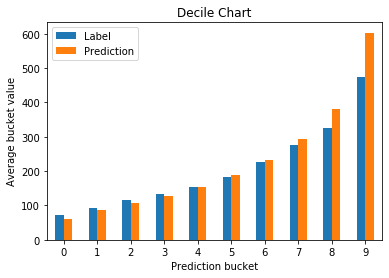

In [56]:
ax = decile_df[['y_true', 'y_pred']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

<h2>UNKNOWN FUTURE DATA

In [64]:
#levanto la info
future_data = spark.sql("""
SELECT * FROM tmp.base_ltv_jan2019_c
""")

In [65]:
#Paso a pandas
df_jan19 = future_data.toPandas()

In [66]:
#verifico los datos levantados
df_jan19.head()

,orden,user_id,transaction_id,fecha_1er_compra,pais,plataforma,producto,viaje,items,income,income_post_compra,gb,paxs,duracion,anticipacion,gb_anual
0,1,ce1eea09-a296-4d52-b3df-93d815d47e06,25428077000,2019-01-01,AR,Site-Desktop,Vuelos,Nac,1,HIGH,HIGH,107.758461,1,7,42.0,NaN
1,1,91cd4a64-c9ff-4741-b5c6-01cc53ed9be8,984301079200,2019-01-23,AR,Site-Desktop,Vuelos,Int,1,LOW,LOW,1264.777344,2,19,99.0,NaN
2,1,55da7c69-42ff-4d4e-8dad-969e6c081d87,546856078000,2019-01-11,BR,Site-Desktop,Carrito,Int,2,MEDIUM,MEDIUM,3664.113892,2,15,24.0,NaN
3,1,315fb49e-79f5-46f4-9c4d-3710223c8f92,798791079200,2019-01-23,MX,Site-Desktop,Carrito,Nac,3,MEDIUM,LOW,977.550892,2,4,103.0,NaN
4,1,df383217-2c32-437d-b456-10cce39fa19e,186486078300,2019-01-14,CO,App,Vuelos,Nac,1,LOW,LOW,77.434059,2,3,76.0,NaN


In [67]:
#me quedo con las que me interesan
df_jan = df_jan19[CATEGORICAL_FEATURES + NUMERIC_FEATURES]

In [69]:
#completo los campos vacíos
df_jan['gb_anual'] = df_jan['gb_anual'].fillna(0.)
df_jan['income_post_compra'] = df_jan['income_post_compra'].fillna('UNKNOWN')
df_jan['duracion']  = df_jan['duracion'].fillna(0.)

/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithC

In [70]:
for cat_col in CATEGORICAL_FEATURES:
    df_jan[cat_col] = df_jan[cat_col].astype('category')

for num_col in NUMERIC_FEATURES:
    df_jan[num_col] = df_jan[num_col].astype('float32')

df_jan['log_gb'] = (np.log(df_jan['gb']).astype('float32'))

/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [71]:
df_jan

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual,log_gb
0,AR,Site-Desktop,Vuelos,HIGH,Nac,1.0,107.758461,1.0,7.0,42.0,0.000000,4.679892
1,AR,Site-Desktop,Vuelos,LOW,Int,1.0,1264.777344,2.0,19.0,99.0,0.000000,7.142652
2,BR,Site-Desktop,Carrito,MEDIUM,Int,2.0,3664.113770,2.0,15.0,24.0,0.000000,8.206342
3,MX,Site-Desktop,Carrito,LOW,Nac,3.0,977.550903,2.0,4.0,103.0,0.000000,6.885050
4,CO,App,Vuelos,LOW,Nac,1.0,77.434059,2.0,3.0,76.0,0.000000,4.349427
...,...,...,...,...,...,...,...,...,...,...,...,...
241727,CO,Site-Mobile,Vuelos,LOW,Nac,1.0,60.341576,1.0,2.0,20.0,276.152771,4.100021
241728,BR,Site-Desktop,Vuelos,HIGH,Nac,1.0,247.224457,3.0,2.0,143.0,221.120010,5.510297
241729,AR,Site-Desktop,Hoteles,LOW,Nac,1.0,311.624847,3.0,3.0,7.0,2350.186279,5.741800
241730,AR,Site-Desktop,Vuelos,HIGH,Int,1.0,666.298523,1.0,50.0,33.0,0.000000,6.501738


In [72]:
for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df_jan[key] = encoder.fit_transform(df_jan[key])

/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241732 entries, 0 to 241731
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pais                241732 non-null  int64  
 1   plataforma          241732 non-null  int64  
 2   producto            241732 non-null  int64  
 3   income_post_compra  241732 non-null  int64  
 4   viaje               241732 non-null  int64  
 5   items               241732 non-null  float32
 6   gb                  241732 non-null  float32
 7   paxs                241732 non-null  float32
 8   duracion            241732 non-null  float32
 9   anticipacion        241732 non-null  float32
 10  gb_anual            241732 non-null  float32
 11  log_gb              241732 non-null  float32
dtypes: float32(7), int64(5)
memory usage: 15.7 MB


In [74]:
def feature_dict(df_jan):
        features = {k: v.values for k, v in dict(df_jan[CATEGORICAL_FEATURES]).items()}
        features['numeric'] = df_jan['log_gb'].values
        return features


variables = ['pais','plataforma','producto','income_post_compra','viaje','log_gb']

df_jan_features = df_jan[variables]    
X_jan, y_jan = feature_dict(df_jan_features), df_jan['gb_anual'].values #label
            

In [75]:
X_jan

{'pais': array([0, 0, 1, ..., 0, 0, 2]),
 'plataforma': array([1, 1, 1, ..., 1, 1, 1]),
 'producto': array([9, 9, 5, ..., 7, 9, 9]),
 'income_post_compra': array([0, 1, 2, ..., 1, 0, 1]),
 'viaje': array([1, 0, 0, ..., 1, 0, 1]),
 'numeric': array([4.679892 , 7.1426516, 8.206342 , ..., 5.7418   , 6.5017376,
        4.0872316], dtype=float32)}

In [76]:
logits_jan = model.predict(x=X_jan, batch_size=1024)
y_pred_jan = ltv.zero_inflated_lognormal_pred(logits_jan).numpy().flatten()

In [77]:
y_pred_jan

array([167.02995 , 356.007   , 827.3818  , ..., 126.4792  , 393.90756 ,
        73.516136], dtype=float32)

In [78]:
len(y_pred_jan)

241732

In [79]:
df_pred_jan = pd.DataFrame({
    'y_true': y_jan,
    'y_pred': y_pred_jan,
})
df_pred_jan.head()

,y_true,y_pred
0,0.0,167.029953
1,0.0,356.006989
2,0.0,827.381775
3,0.0,290.730469
4,0.0,86.291077


In [80]:
df_pred_jan = df_pred_jan.sort_values(by='y_pred').reset_index(drop=True)
df_pred_jan

,y_true,y_pred
0,0.000000,8.183548
1,0.000000,9.995440
2,0.000000,11.072495
3,0.000000,11.928774
4,0.000000,14.443232
...,...,...
241727,4712.062012,1954.350830
241728,0.000000,1958.985718
241729,0.000000,1964.918701
241730,26291.662109,2055.790527


In [81]:
df_pred_jan['decile'] = pd.qcut(df_pred_jan['y_pred'].rank(method='first'), 10, labels=[i for i in range(10)])
df_pred_jan['buyer'] = df_pred_jan['y_true'].apply(lambda x: 1 if x > 0 else 0)
df_pred_jan

,y_true,y_pred,decile,buyer
0,0.000000,8.183548,0,0
1,0.000000,9.995440,0,0
2,0.000000,11.072495,0,0
3,0.000000,11.928774,0,0
4,0.000000,14.443232,0,0
...,...,...,...,...
241727,4712.062012,1954.350830,9,1
241728,0.000000,1958.985718,9,0
241729,0.000000,1964.918701,9,0
241730,26291.662109,2055.790527,9,1


In [82]:
pivot_jan = pd.pivot_table(df_pred_jan, values=['y_true', 'y_pred', 'buyer'], index='decile',
                    aggfunc={'y_true': [min, max,len, np.mean, sum],
                             'y_pred': [min, max,len, np.mean, sum],
                             'buyer': sum
                             })

pivot_jan

buyer   y_pred                                                     \
         sum      len          max        mean         min           sum   
decile                                                                     
0       6331  24174.0    83.139374   66.708504    8.183548  1.612611e+06   
1       6482  24173.0   103.085678   92.964821   83.139763  2.247239e+06   
2       6617  24173.0   123.986755  113.421242  103.088524  2.741732e+06   
3       6615  24173.0   147.968750  135.314957  123.987144  3.270968e+06   
4       7134  24173.0   179.900696  163.401291  147.969055  3.949900e+06   
5       7439  24173.0   219.999069  199.161758  179.904068  4.814337e+06   
6       7819  24173.0   271.705811  244.664581  220.000443  5.914277e+06   
7       8201  24173.0   338.912292  303.641022  271.707886  7.339914e+06   
8       8717  24173.0   447.177155  387.354401  338.914459  9.363518e+06   
9       9562  24174.0  2194.362549  600.633850  447.177826  1.451972e+07   

         y_true                                                      
            len            max        mean        min           sum  
decile                                                               
0       24174.0   42937.710938   74.767410   0.000000  1.807427e+06  
1       24173.0   14980.110352  107.061554   0.000000  2.587999e+06  
2       24173.0   12171.538086  119.194878 -26.909651  2.881298e+06  
3       24173.0   12237.154297  139.118591   0.000000  3.362914e+06  
4       24173.0   38591.906250  172.982178   0.000000  4.181498e+06  
5       24173.0   64025.890625  213.859711   0.000000  5.169630e+06  
6       24173.0   42340.410156  243.512222   0.000000  5.886421e+06  
7       24173.0   34788.652344  288.230011   0.000000  6.967384e+06  
8       24173.0   26547.978516  368.910248   0.000000  8.917668e+06  
9       24174.0  150487.375000  555.286621   0.000000  1.342350e+07

In [ ]:
pivot_jan.to_csv('stats_jan2019B.csv')

In [ ]:
recompra_jan = (pivot_jan['buyer']['sum']/24174)*100.0
recompra_jan

In [ ]:
df_pred_jan.describe()

In [85]:
#agrego el ltv pronosticado al df
df_jan['ltv_pred'] = y_pred_jan

/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
df_jan['buyer'] = df_jan['gb_anual'].apply(lambda x: 1 if x > 0 else 0)
df_jan

/home/despegar/sparkData/miniconda2/envs/py3-With-Spark/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual,log_gb,ltv_pred,buyer
0,0,1,9,0,1,1.0,107.758461,1.0,7.0,42.0,0.000000,4.679892,167.029953,0
1,0,1,9,1,0,1.0,1264.777344,2.0,19.0,99.0,0.000000,7.142652,356.006989,0
2,1,1,5,2,0,2.0,3664.113770,2.0,15.0,24.0,0.000000,8.206342,827.381775,0
3,4,1,5,1,1,3.0,977.550903,2.0,4.0,103.0,0.000000,6.885050,290.730469,0
4,3,0,9,1,1,1.0,77.434059,2.0,3.0,76.0,0.000000,4.349427,86.291077,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241727,3,2,9,1,1,1.0,60.341576,1.0,2.0,20.0,276.152771,4.100021,50.643986,1
241728,1,1,9,0,1,1.0,247.224457,3.0,2.0,143.0,221.120010,5.510297,218.296280,1
241729,0,1,7,1,1,1.0,311.624847,3.0,3.0,7.0,2350.186279,5.741800,126.479202,1
241730,0,1,9,0,0,1.0,666.298523,1.0,50.0,33.0,0.000000,6.501738,393.907562,0


In [98]:
pivot_compare = pd.pivot_table(df_jan, values=['gb_anual', 'buyer'] , index='income_post_compra',
                    aggfunc={'gb_anual': [len, np.mean, sum],
                             'buyer': sum
                             })

pivot_compare

buyer  gb_anual                        
                      sum       len        mean         sum
income_post_compra                                         
0                   16934   49516.0  340.581055  16864212.0
1                   34882  122053.0  156.538208  19105958.0
2                   19350   59712.0  261.073730  15589234.0
3                    3751   10451.0  346.984558   3626335.5

In [99]:
pivot_compare.to_csv('compare.csv')

In [109]:
df_ordenado = df_jan.sort_values(by='ltv_pred')
df_ordenado['corte'] = pd.qcut(df_ordenado['ltv_pred'],  [0., 0.528, 0.786, 1.], labels=['L', 'M', 'H'])
df_ordenado

,pais,plataforma,producto,income_post_compra,viaje,items,gb,paxs,duracion,anticipacion,gb_anual,log_gb,ltv_pred,buyer,corte
232415,0,2,4,2,1,1.0,1.547968,1.0,0.0,1.0,0.000000,0.436943,8.183548,0,L
181474,0,2,4,0,1,1.0,1.496985,1.0,0.0,1.0,0.000000,0.403453,9.995440,0,L
5227,0,2,4,1,1,1.0,2.647764,1.0,0.0,1.0,0.000000,0.973715,11.072495,0,L
119914,1,2,4,1,1,1.0,2.707614,1.0,0.0,1.0,0.000000,0.996068,11.928774,0,L
103842,1,1,4,1,1,1.0,2.926204,1.0,0.0,1.0,0.000000,1.073706,14.443232,0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131062,1,1,9,2,0,1.0,18615.593750,4.0,25.0,189.0,4712.062012,9.831755,1954.350830,1,H
48845,2,0,5,0,0,3.0,10867.962891,5.0,7.0,90.0,0.000000,9.293574,1958.985718,0,H
851,0,1,7,1,1,1.0,30073.000000,4.0,5.0,352.0,0.000000,10.311383,1964.918701,0,H
37343,4,1,9,0,0,1.0,19094.822266,7.0,25.0,161.0,26291.662109,9.857172,2055.790527,1,H


In [110]:
pivot_compare_ltv = pd.pivot_table(df_ordenado, values=['gb_anual', 'buyer'] , index='corte',
                    aggfunc={'gb_anual': [len, np.mean, sum],
                             'buyer': sum
                             })

pivot_compare_ltv

buyer  gb_anual                        
         sum       len        mean         sum
corte                                         
L      35216  127634.0  126.676056  16168172.0
M      20216   62367.0  250.251770  15607453.0
H      19485   51731.0  452.535492  23410114.0

In [111]:
pivot_compare_ltv.to_csv('pivot_compare_ltv.csv')